## 导包

In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
# %matplotlib widget
from matplotlib import pyplot as plt
from numpy import matrix as mat
from torch.nn.modules import loss
from functorch import make_functional, vmap, grad, jacrev, hessian
import jax
import time
from matplotlib.ticker import FuncFormatter
pi=np.pi

## 模型

In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size, # 输入层神经元数
        hidden_size, # 隐藏层神经元数
        output_size, # 输出层神经元数
        depth, # 隐藏层数
        act=torch.nn.Tanh(), # 输入层和隐藏层的激活函数
    ):
        super(Network, self).__init__()

        # 输入层
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        #self.relu = nn.ReLU() torch.nn.Tanh()
        self.tanh = act
        # 隐藏层
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        #self.relu = nn.ReLU()
        self.tanh = act
        # 输出层
        self.layer4 = nn.Linear(in_features=hidden_size, out_features=output_size,bias=False)



    def forward(self, x):
        x = self.layer1(x)
        #x = self.relu(x)
        x= self.tanh(x)
        x = self.layer2(x)
        #x = self.relu(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer4(x)

        return x
    

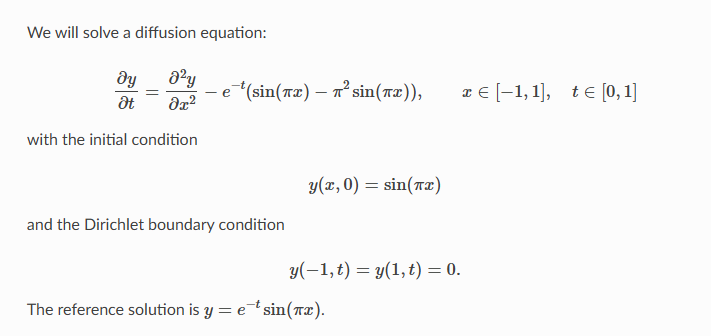

In [22]:
"""PINN_S"""
class PINN_S:
    def __init__(self):
        self.input_size = 2
        self.hidden_size =20
        self.output_size = 1
        self.depth = 1
        global device
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # 选择使用GPU还是CPU
        self.model = Network(self.input_size, self.hidden_size,  self.output_size, self.depth, act=  torch.nn.Tanh() ).double().to(device)  # 定义神经网络
        self.p_number = self.input_size * self.hidden_size + self.hidden_size + (self.hidden_size * self.hidden_size + self.hidden_size)*2 +self.hidden_size * self.output_size  # 参数的个数
        print('model # of parameters',self.p_number)
        
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)


        
        
        self.loss_record=np.zeros(100000)
        self.loss_iter=0
        self.Sampledata=np.array([])
        self.time_iter=0
        self.time_record=np.zeros(100000)

        
    
    def new_sampling(self,i):
            """
            生成新的采样点
            i - random seed 
            points_num - # of points inside 
            """
            # 指定区间
            torch.set_default_dtype(torch.float64)
            lower_boundx = -1
            upper_boundx = 1
            lower_boundy=0
            upper_boundy=1
            random_samples = 7
            torch.manual_seed(1+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(2+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy  
            self.X_inside = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T  
            self.X_inside=self.X_inside.to(device)
            self.X_inside.requires_grad = True
            self.X_inside_num=self.X_inside.size(0) 
            
            random_samples = 10
            torch.manual_seed(3+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(4+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy 
            bc1 = torch.stack(torch.meshgrid(torch.tensor(lower_boundx).double(), y)).reshape(2, -1).T  # x=-1边界
            bc2 = torch.stack(torch.meshgrid(torch.tensor(upper_boundx).double(), y)).reshape(2, -1).T  # x=+1边界
            random_samples=10
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            bc3 = torch.stack(torch.meshgrid(x, torch.tensor(lower_boundy).double())).reshape(2, -1).T # y=0边界

            self.X_boundary = torch.cat([bc1, bc2, bc3])  # 将所有边界处的时空坐标点整合为一个张量
            self.X_boundary1=torch.cat([bc1, bc2])
            self.X_boundary2=bc3

            
            self.X_boundary_num1=self.X_boundary1.size(0)
            self.X_boundary_num2=self.X_boundary2.size(0)
            self.X_boundary_num=self.X_boundary_num1+self.X_boundary_num2
            self.X_inside_num=self.X_inside.size(0)

        
            self.X_boundary=self.X_boundary.to(device)
            self.X_boundary1=self.X_boundary1.to(device)
            self.X_boundary2=self.X_boundary2.to(device)
            self.X_inside=self.X_inside.to(device)

            self.X_boundary.requires_grad = True
            self.X_boundary1.requires_grad = True
            self.X_boundary2.requires_grad = True

            self.X_boundary=self.X_boundary.double()
            self.X_boundary1=self.X_boundary1.double()
            self.X_boundary2=self.X_boundary2.double()
            self.X_inside=self.X_inside.double()

    
    def LM(self,opt_num, step,deterministic=True,mu=1):
        """ 
        Parameters:
        opt_num -  优化的参数数量 
        step: LM 下降的次数 
        deterministic: 是否要严格下降 True 为是
        mu: 1 为LM method， 0 为Gauss-Newton => deterministic=False
        需要修改的部分：fx_fun 函数; J_func 函数; 
        """

        if mu==0:
            deterministic=False
        p_number = self.p_number
        params = torch.cat([p.view(-1) for p in self.model.parameters()], dim=0).to(device) # 把模型参数展平成一维向量

        
    
        def f(params, input_data):
            
            with torch.no_grad():
                a = self.hidden_size * self.input_size
                self.model.layer1.weight.data = params[:a].reshape(self.hidden_size, self.input_size).clone()  # layer1的权重
                self.model.layer1.bias.data = params[a:a + self.hidden_size].clone()  # layer1的偏置
                a += self.hidden_size
                self.model.layer2.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer2.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer3.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer3.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer4.weight.data = params[a:a + self.output_size * self.hidden_size].reshape(self.output_size, self.hidden_size).clone()  # layer3的权重
                a += self.output_size * self.hidden_size
                # self.model.layer3.bias.data = params[a].clone()  # layer3的偏置
            
            model_output=torch.vmap(self.model)(input_data)    
            
            return model_output
        
        def fx_fun(params)->np.array:
            
            f_inside = f(params, self.X_inside)  # 更换模型中的参数
            f_inside.require_grad = True
            du_dX = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
                )[0][:,0]  
            du_dY = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
            )[0][:,1]  
            du_dxx = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=du_dX,
                grad_outputs=torch.ones_like(du_dX),
                retain_graph=True,
                create_graph=True
            )[0][:, 0]
            
        
            fx = du_dY-du_dxx + torch.exp(-self.X_inside[:,1])*(torch.sin(pi*self.X_inside[:,0])-(pi**2)*torch.sin(pi*self.X_inside[:,0]))
            fx=fx.to(device)
            fx=fx.view(-1)
            
            f_bd = f(params, self.X_boundary1)
            
            fx_bd = f_bd.view(-1)
            

            fx = torch.cat((fx, fx_bd), dim=0)

            f_ini=f(params, self.X_boundary2)
            f_ini=f_ini.view(-1)
            
            fx_ini = f_ini-torch.sin(torch.pi*self.X_boundary2[:,0])
            
            fx = torch.cat((fx, fx_ini), dim=0)
            fx=fx.t()
            return fx

        def F_fun(fx)->torch.tensor:
            '''计算L2范数'''
            F_p = 0
            for i in range(self.X_inside_num+self.X_boundary_num):
                F_p += (fx[i]) ** 2 
            F_p /= (self.X_inside_num+self.X_boundary_num)
            return F_p
        

        def J_func(params)->torch.tensor:
            J = torch.zeros(self.X_inside_num+self.X_boundary_num, p_number).to(device)# 初始化雅可比矩阵
            params.requires_grad_(True)
            def Inter(params, input):
                
                f_inside = f(params, input)  # 更换模型中的参数
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    f_inside=fm(input, func_params) 
                    d1u = jacrev((fm))(input, func_params)            
                    d2u = jacrev(jacrev(fm))(input,func_params)
                    
                    du_dY=d1u[1]    
                    du_dX=d1u[0]    
                    du_dxx=d2u[0][0]     
                    
                    fx = du_dY-du_dxx + torch.exp(-input[1])*(torch.sin(pi*input[0])-(pi**2)*torch.sin(pi*input[0]))
                    # print('du_dY',du_dY)
                    return fx
                    
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            def Bound(params,input):
                f_bound=f(params,input)
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    fx = fm(input, func_params)

                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result = J_d.detach()
                
                return result
            
            def INIC(params,input):
                f_bound=f(params,input)
                
                def SINP(x):
                    return torch.sin(torch.pi*x)
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):           
                    fx = fm(input, func_params)-torch.sin(torch.pi*input[0])
                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            J[range(self.X_inside_num), :] = Inter(params, self.X_inside)
            J[range(self.X_inside_num, self.X_inside_num + self.X_boundary_num1), :] = Bound(params, self.X_boundary1)
            J[range(self.X_inside_num + self.X_boundary_num1, self.X_inside_num + self.X_boundary_num1+self.X_boundary_num2), :] = INIC(params, self.X_boundary2)
            
            
            return J
        
        
        #参数准备
        k = 0
        kmax = step
        p = params.to(device)
        J = J_func(p)
        A = torch.matmul(J.t(),J)
        F_p = torch.tensor(10).to(device)
        F_pnew = 0
        alpha = 1
        lambda_up = 10
        lambda_down = 0.1
        diag = torch.eye(p_number)
        elapsed_time_ms=0
        ####随机选择部分参数进行优化
        selected_columns = np.random.choice(p_number, opt_num, replace=False)
        ####
        if deterministic:
            '''严格lm'''
            while (k < kmax):  # (not found)
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
                k = k + 1
                
                J_opt=J[:,selected_columns]
                A_opt= torch.matmul(J_opt.t(),J_opt)
                diag=torch.eye(A_opt.shape[0]).to(device)
                H = A_opt + mu * diag
                
                fx = fx_fun(p)
                
                try:              
                    h_lm = torch.linalg.solve(-H, torch.matmul(J_opt.t(),fx))             
                except:
                    eigenvalues, eigenvectors = torch.linalg.eig(-H)
                    # 输出特征值和特征向量
                    print("特征值：", eigenvalues)
                    print("特征向量：\n", eigenvectors)
                    print('singular matrix ')
                    break
               
                if (torch.abs(F_p - F_pnew)/torch.tensor(F_p).to(device)< 1e-7):  # 满足收敛条件
                    print('converge in para updates')
                    break
                else:
                    
                    p_new=p.clone()
                    p_new[selected_columns]+= alpha * torch.squeeze(h_lm)
                    
                    
                    F_p = F_fun(fx)
                    
                    fx_new = fx_fun(p_new)
                    F_pnew = F_fun(fx_new)
                    
                    
                    o = F_p - F_pnew
                    if o > 0:
                        self.loss_record[self.loss_iter] = float(F_pnew.item())
                        self.loss_iter += 1
                        if k%10==0:
                            print("steps ", k, end=' ')
                            print('accept move')
                            print("Loss =", F_p.item(), end=' ')
                            print("Loss new=", F_pnew.item())
                            print(f'Elapsed: {elapsed_time_ms:.1f}ms')  
                        p = p_new
                        J = J_func(p)  # update J
                        mu = mu * lambda_down  # lower limit u =1e-11
                       
                        
                    else:
                        if k % 10 == 0:print("reject move")
                        mu = mu * lambda_up  # Up limit u =1e11
                    end_event.record()
                    torch.cuda.synchronize()  # Wait for the events to be recorded!
                    elapsed_time_ms = start_event.elapsed_time(end_event)
                    self.time_record[self.time_iter] = elapsed_time_ms
                    self.time_iter += 1
                    
                
        else:
            pass
                    
        self.avg_time = np.mean(self.time_record[self.time_record != 0])        
                
        return p
    
    
    def plt(self):
        pass

    def error(self):
        pass
    

## 选择参数训练 


In [4]:

torch.cuda.empty_cache() 
pinns_all=PINN_S()
for i in range(10):
    pinns_all.new_sampling(9+i)
    pinns_all.LM(920,100,True)

# np.save("losspinnsall_record99.npy", pinns_all.loss_record)

model # of parameters 920


f:\Anaconda3\envs\my-env\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated func

reject move
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 3.013076228131889e-05 Loss new= 1.798675149206654e-05
Elapsed: 49.1ms
steps  70 accept move
Loss = 8.202842289135219e-06 Loss new= 7.203920939187691e-06
Elapsed: 55.7ms
steps  80 accept move
Loss = 4.631740645047345e-06 Loss new= 4.2100886817229406e-06
Elapsed: 47.9ms
steps  90 accept move
Loss = 3.0191685682420928e-06 Loss new= 2.810149504977435e-06
Elapsed: 48.7ms
reject move
steps  10 accept move
Loss = 1.556214424643347e-05 Loss new= 1.3691072337080575e-05
Elapsed: 45.0ms
steps  20 accept move
Loss = 9.151991687742405e-06 Loss new= 8.395238190600204e-06
Elapsed: 45.2ms
steps  30 accept move
Loss = 6.167437274020564e-06 Loss new= 5.753559114106333e-06
Elapsed: 49.9ms
steps  40 accept move
Loss = 4.462955858352427e-06 Loss new= 4.209773135330833e-06
Elapsed: 49.9ms
steps  50 accept move
Loss = 3.3873053483246767e-06 Loss new= 3.2194791616037045e-06
Elapsed: 47.9ms
steps  60 accept move
Loss = 2.6

In [10]:
torch.cuda.empty_cache() 
pinns_ran=PINN_S()
for i in range(10):
    pinns_ran.new_sampling(9+i)
    pinns_ran.LM(400,100,True)

model # of parameters 920


C:\Windows\Temp\ipykernel_3132\1647241583.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (torch.abs(F_p - F_pnew)/torch.tensor(F_p).to(device)< 1e-7):  # 满足收敛条件


steps  10 accept move
Loss = 0.538646943766016 Loss new= 0.3469370747181397
Elapsed: 83.5ms
reject move
reject move
steps  40 accept move
Loss = 0.0010185040728788513 Loss new= 0.0009967152047132926
Elapsed: 72.5ms
steps  50 accept move
Loss = 4.4625622206817306e-05 Loss new= 3.957836835703921e-05
Elapsed: 32.6ms
steps  60 accept move
Loss = 2.723745975348836e-05 Loss new= 2.520813813560012e-05
Elapsed: 30.4ms
steps  70 accept move
Loss = 1.909419179089265e-05 Loss new= 1.7902407865228342e-05
Elapsed: 33.8ms
steps  80 accept move
Loss = 1.3959908488470631e-05 Loss new= 1.3133509262815404e-05
Elapsed: 43.1ms
steps  90 accept move
Loss = 1.0295620769764186e-05 Loss new= 9.685747903099069e-06
Elapsed: 38.8ms
steps  100 accept move
Loss = 7.574124446752286e-06 Loss new= 7.119792670799354e-06
Elapsed: 33.9ms
steps  10 accept move
Loss = 3.7941391782926645e-05 Loss new= 3.278647295865295e-05
Elapsed: 42.6ms
steps  20 accept move
Loss = 2.0909520741392653e-05 Loss new= 1.9034281632763796e-05


model # of parameters 920


f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html


steps  10 accept move
Loss = 2.9325707128895013 Loss new= 2.553890069236931
Elapsed: 27.8ms
reject move
steps  30 accept move
Loss = 0.6278586113398299 Loss new= 0.6137296421994792
Elapsed: 31.6ms
reject move
reject move
reject move
reject move
steps  80 accept move
Loss = 0.42829311935118436 Loss new= 0.42438802275671694
Elapsed: 29.3ms
reject move
steps  100 accept move
Loss = 0.40425455547258865 Loss new= 0.4015048708820303
Elapsed: 35.5ms
steps  10 accept move
Loss = 2.6183666042714364 Loss new= 2.191602289538483
Elapsed: 36.4ms
reject move
reject move
steps  40 accept move
Loss = 0.991036049835849 Loss new= 0.9747780797105783
Elapsed: 75.8ms
reject move
steps  60 accept move
Loss = 0.6697413243804289 Loss new= 0.639457010788787
Elapsed: 69.3ms
reject move
steps  80 accept move
Loss = 0.5075900655314062 Loss new= 0.5027802519466696
Elapsed: 29.5ms
steps  90 accept move
Loss = 0.49059826773002285 Loss new= 0.4754440697164046
Elapsed: 80.1ms
reject move
reject move
reject move
steps 

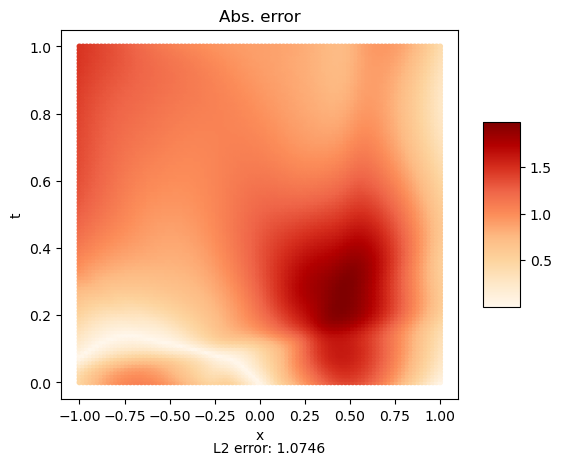

model # of parameters 920
reject move
reject move
reject move
steps  40 accept move
Loss = 0.025280877943052855 Loss new= 0.025243450268586636
Elapsed: 76.4ms
steps  50 accept move
Loss = 0.015150545845813036 Loss new= 0.014511700550565108
Elapsed: 74.0ms
steps  60 accept move
Loss = 0.011063431916909025 Loss new= 0.009937210313972069
Elapsed: 31.1ms
steps  70 accept move
Loss = 0.006995226694169349 Loss new= 0.006570915056175971
Elapsed: 30.7ms
reject move
reject move
steps  100 accept move
Loss = 0.0024082509657424355 Loss new= 0.0023701359024866516
Elapsed: 32.1ms
reject move
steps  20 accept move
Loss = 0.021711533540131136 Loss new= 0.019735381585199895
Elapsed: 81.4ms
steps  30 accept move
Loss = 0.009941558595222307 Loss new= 0.009110372509774914
Elapsed: 30.8ms
steps  40 accept move
Loss = 0.005728557377996455 Loss new= 0.005357501756534423
Elapsed: 77.6ms
steps  50 accept move
Loss = 0.0026651262964404654 Loss new= 0.0023594510674385455
Elapsed: 29.9ms
steps  60 accept move
Lo

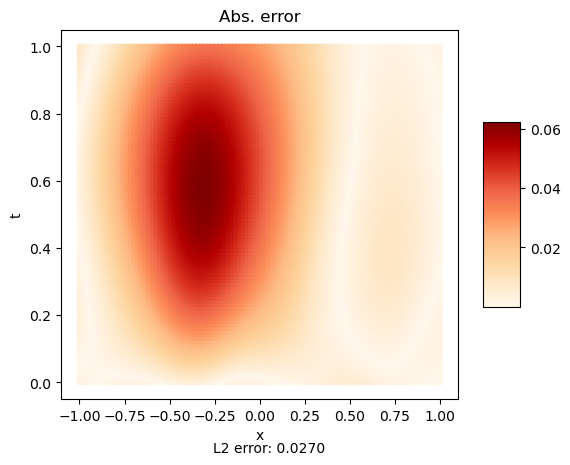

model # of parameters 920
steps  10 accept move
Loss = 0.47855732837436454 Loss new= 0.33558712227407056
Elapsed: 32.1ms
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 0.00271212098502458 Loss new= 0.0026962032902909812
Elapsed: 79.1ms
steps  70 accept move
Loss = 0.0008068599808006637 Loss new= 0.000715108126205387
Elapsed: 34.4ms
steps  80 accept move
Loss = 0.0004906796186673033 Loss new= 0.0004512566404801666
Elapsed: 31.8ms
steps  90 accept move
Loss = 0.0003355045811808702 Loss new= 0.00031521203899182083
Elapsed: 31.0ms
steps  100 accept move
Loss = 0.00025672477806967564 Loss new= 0.00024592631326093796
Elapsed: 31.8ms
steps  10 accept move
Loss = 0.0011376900375732273 Loss new= 0.000766906067799603
Elapsed: 31.4ms
steps  20 accept move
Loss = 0.00033225323172852257 Loss new= 0.0002593471124693166
Elapsed: 31.9ms
steps  30 accept move
Loss = 0.00014072245187890848 Loss new= 0.00013131368239588894
Elapsed: 30.5ms
steps  40 accept move
Loss = 0.00011

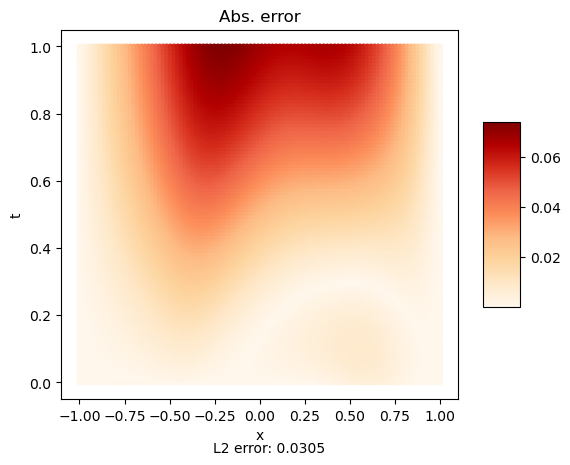

model # of parameters 920
steps  10 accept move
Loss = 0.441623354997668 Loss new= 0.13248687049971922
Elapsed: 37.7ms
steps  20 accept move
Loss = 0.0006916288921964997 Loss new= 0.0002338360668276882
Elapsed: 40.7ms
steps  30 accept move
Loss = 0.00011107889365194609 Loss new= 9.67907905620202e-05
Elapsed: 39.3ms
steps  40 accept move
Loss = 5.802034447592846e-05 Loss new= 5.1417726683406475e-05
Elapsed: 38.8ms
steps  50 accept move
Loss = 3.26852633508236e-05 Loss new= 2.9426030589239467e-05
Elapsed: 36.9ms
steps  60 accept move
Loss = 1.999702097384104e-05 Loss new= 1.830655966447855e-05
Elapsed: 36.9ms
steps  70 accept move
Loss = 1.3263813620807822e-05 Loss new= 1.232886476518485e-05
Elapsed: 39.6ms
steps  80 accept move
Loss = 9.46570208613666e-06 Loss new= 8.920435146769213e-06
Elapsed: 36.7ms
reject move
reject move
steps  10 accept move
Loss = 0.0002442762003246882 Loss new= 0.0001555479413304867
Elapsed: 39.1ms
steps  20 accept move
Loss = 4.254601201912695e-05 Loss new= 3.7

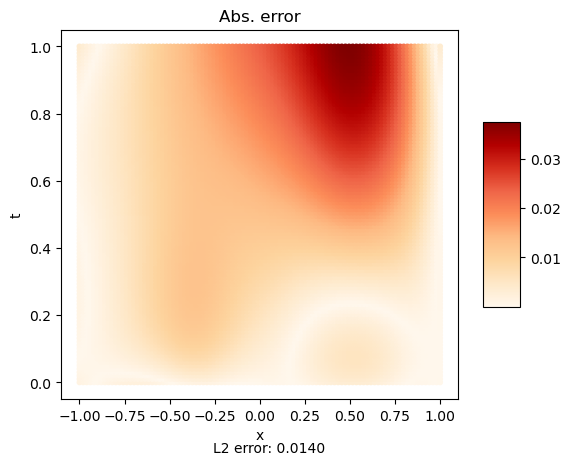

model # of parameters 920
reject move
reject move
reject move
reject move
steps  50 accept move
Loss = 0.0014304204099536396 Loss new= 0.0005630981302197548
Elapsed: 39.9ms
steps  60 accept move
Loss = 0.00013971103782171366 Loss new= 0.00012017096372210525
Elapsed: 34.7ms
steps  70 accept move
Loss = 8.729440223780832e-05 Loss new= 8.238834362765588e-05
Elapsed: 43.1ms
steps  80 accept move
Loss = 6.713477711875087e-05 Loss new= 6.406390418644863e-05
Elapsed: 31.9ms
steps  90 accept move
Loss = 5.3729097535566226e-05 Loss new= 5.153902940257489e-05
Elapsed: 32.3ms
steps  100 accept move
Loss = 4.3990367287852256e-05 Loss new= 4.2363855054471164e-05
Elapsed: 33.4ms
reject move
steps  20 accept move
Loss = 0.00028757425667415396 Loss new= 0.00023095727050092944
Elapsed: 33.1ms
steps  30 accept move
Loss = 0.00014189561606806568 Loss new= 0.00012941394967237328
Elapsed: 32.9ms
steps  40 accept move
Loss = 9.489515594463407e-05 Loss new= 8.892374476400539e-05
Elapsed: 37.4ms
steps  50 acc

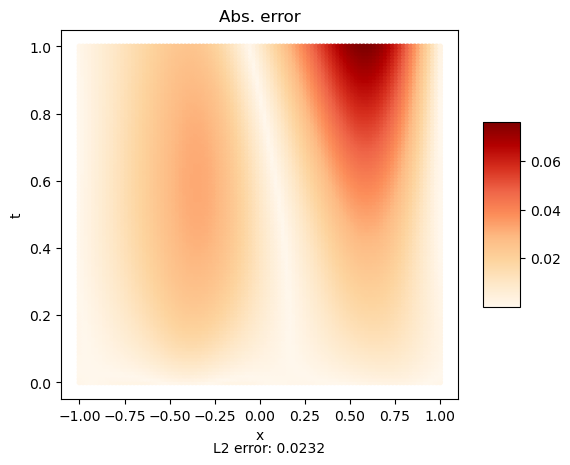

model # of parameters 920
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 1.4174170872537484e-05 Loss new= 1.2442125895741007e-05
Elapsed: 32.2ms
steps  20 accept move
Loss = 8.597945359993967e-06 Loss new= 8.005428678847548e-06
Elapsed: 32.0ms
steps  30 accept move
Loss = 6.350371780120656e-06 Loss new= 6.059283732227271e-06
Elapsed: 36.4ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  40 accept move
Loss = 1.624352531169356e-07 Loss new= 1.2576312560943948e-07
Elapsed: 41.9ms
steps  50 accept move
Loss = 6.19395961882184e-08 Loss new= 5.500958241816323e-08
Elapsed: 37.4

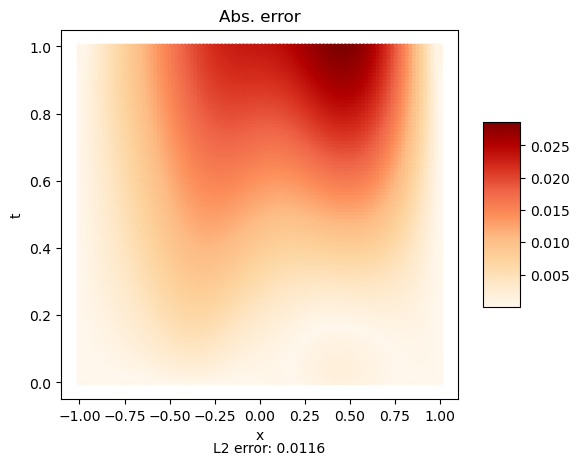

model # of parameters 920
steps  10 accept move
Loss = 0.6727343115411345 Loss new= 0.13979447543327084
Elapsed: 95.3ms
steps  20 accept move
Loss = 0.000580380960890133 Loss new= 0.00010239390377013677
Elapsed: 41.0ms
steps  30 accept move
Loss = 3.9757994200742903e-05 Loss new= 3.5854986221323925e-05
Elapsed: 37.2ms
steps  40 accept move
Loss = 2.5751552367467932e-05 Loss new= 2.3995487662392272e-05
Elapsed: 40.3ms
steps  50 accept move
Loss = 1.861161021126637e-05 Loss new= 1.756405237597546e-05
Elapsed: 39.3ms
steps  60 accept move
Loss = 1.4167998070983294e-05 Loss new= 1.3475559372610154e-05
Elapsed: 40.6ms
steps  70 accept move
Loss = 1.1158615059129039e-05 Loss new= 1.0672286891769007e-05
Elapsed: 36.6ms
steps  80 accept move
Loss = 9.009088088320158e-06 Loss new= 8.652741815170946e-06
Elapsed: 38.4ms
steps  90 accept move
Loss = 7.414244744216945e-06 Loss new= 7.144795356116033e-06
Elapsed: 37.0ms
steps  100 accept move
Loss = 6.1966760262146055e-06 Loss new= 5.987966001015767

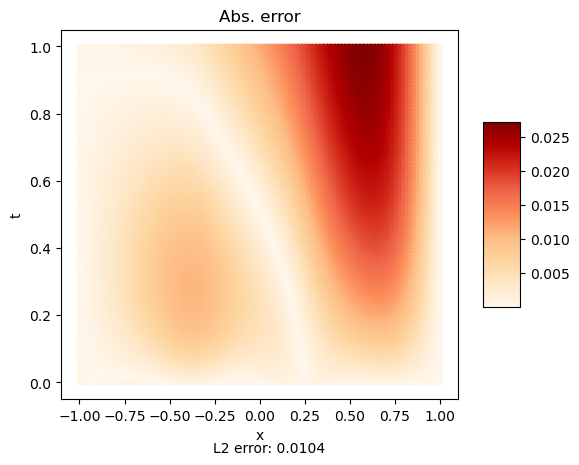

model # of parameters 920
reject move
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 3.619326562059653e-05 Loss new= 2.5570715534618753e-05
Elapsed: 31.4ms
steps  70 accept move
Loss = 1.755953999134101e-05 Loss new= 1.689796564771908e-05
Elapsed: 43.7ms
steps  80 accept move
Loss = 1.4890100860007215e-05 Loss new= 1.4465924891693781e-05
Elapsed: 37.3ms
steps  90 accept move
Loss = 1.2940531511222531e-05 Loss new= 1.2594086305564148e-05
Elapsed: 47.0ms
steps  100 accept move
Loss = 1.132144481478566e-05 Loss new= 1.1028675530552246e-05
Elapsed: 34.7ms
steps  10 accept move
Loss = 3.496091062016509e-05 Loss new= 3.020644179057081e-05
Elapsed: 32.1ms
steps  20 accept move
Loss = 1.9917693666344863e-05 Loss new= 1.827243574940184e-05
Elapsed: 35.1ms
steps  30 accept move
Loss = 1.3580534374160803e-05 Loss new= 1.2748468708933735e-05
Elapsed: 35.5ms
steps  40 accept move
Loss = 1.0267316233430762e-05 Loss new= 9.801255125897997e-06
Elapsed: 34.5ms
steps  50 ac

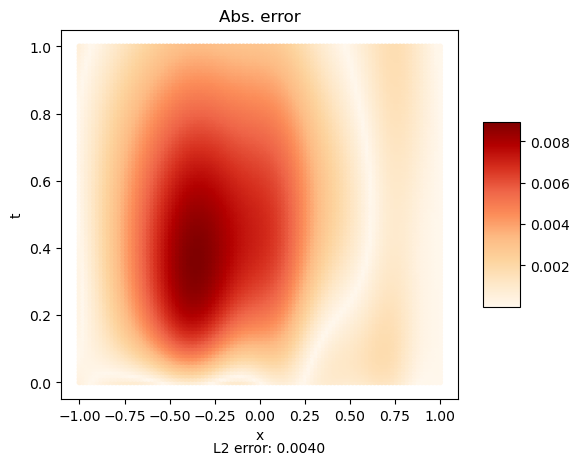

model # of parameters 920
steps  10 accept move
Loss = 0.18304855627781716 Loss new= 0.013569902306766723
Elapsed: 36.2ms
steps  20 accept move
Loss = 0.00023668192482792987 Loss new= 0.00016753890499702795
Elapsed: 34.6ms
steps  30 accept move
Loss = 5.5774353036835014e-05 Loss new= 4.432267444229977e-05
Elapsed: 33.2ms
steps  40 accept move
Loss = 2.0433071420453985e-05 Loss new= 1.7365556101842974e-05
Elapsed: 32.3ms
steps  50 accept move
Loss = 9.948070693103872e-06 Loss new= 8.827687664624549e-06
Elapsed: 32.1ms
steps  60 accept move
Loss = 5.840645180546385e-06 Loss new= 5.345868824244883e-06
Elapsed: 32.5ms
steps  70 accept move
Loss = 3.9556985716250655e-06 Loss new= 3.71447900951749e-06
Elapsed: 38.8ms
steps  80 accept move
Loss = 3.017633918901494e-06 Loss new= 2.8934248519636263e-06
Elapsed: 33.9ms
reject move
reject move
steps  10 accept move
Loss = 5.217043927740397e-05 Loss new= 2.508257993187422e-05
Elapsed: 34.3ms
steps  20 accept move
Loss = 8.634871220383615e-07 Loss 

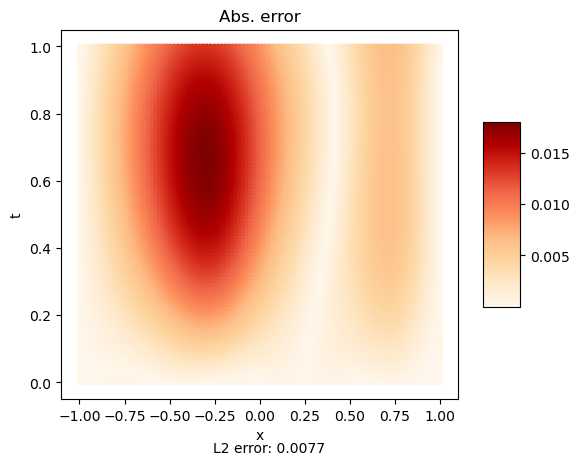

model # of parameters 920
steps  10 accept move
Loss = 0.1787825098654517 Loss new= 0.08743003057798633
Elapsed: 37.5ms
reject move
reject move
reject move
steps  50 accept move
Loss = 0.00042604034291596476 Loss new= 0.00015215991919187896
Elapsed: 39.4ms
steps  60 accept move
Loss = 5.9502059968529404e-05 Loss new= 5.038626599749607e-05
Elapsed: 52.8ms
steps  70 accept move
Loss = 2.7659211445061063e-05 Loss new= 2.417085200039691e-05
Elapsed: 54.5ms
reject move
reject move
reject move
steps  10 accept move
Loss = 2.3598658196222585e-05 Loss new= 2.1263854063949628e-05
Elapsed: 47.8ms
steps  20 accept move
Loss = 1.5013755422747739e-05 Loss new= 1.3896179560192929e-05
Elapsed: 47.5ms
steps  30 accept move
Loss = 1.0421649232091218e-05 Loss new= 9.739304266738442e-06
Elapsed: 49.4ms
steps  40 accept move
Loss = 7.52954940193721e-06 Loss new= 7.082959825445308e-06
Elapsed: 44.1ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move

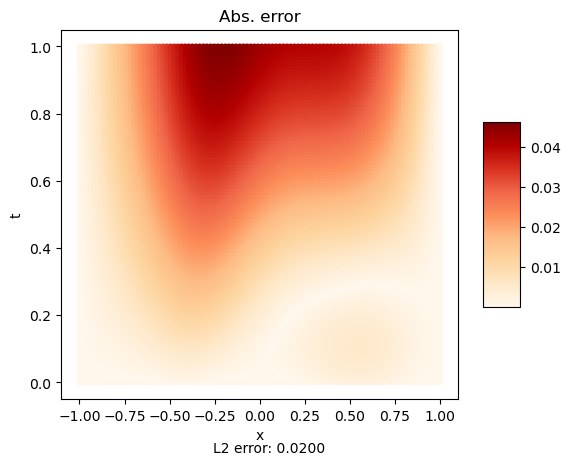

model # of parameters 920
steps  10 accept move
Loss = 0.823057527065363 Loss new= 0.222028560387287
Elapsed: 38.9ms
reject move
reject move
steps  40 accept move
Loss = 0.0002153933509463762 Loss new= 9.044356876713203e-05
Elapsed: 46.7ms
steps  50 accept move
Loss = 2.7609083323546077e-05 Loss new= 2.201969484508822e-05
Elapsed: 43.1ms
steps  60 accept move
Loss = 1.0935417399056014e-05 Loss new= 9.669830699399711e-06
Elapsed: 43.5ms
steps  70 accept move
Loss = 6.918883367536768e-06 Loss new= 6.539812003487438e-06
Elapsed: 40.1ms
steps  80 accept move
Loss = 5.519628415403414e-06 Loss new= 5.336983937648638e-06
Elapsed: 40.0ms
steps  90 accept move
Loss = 4.750850473837568e-06 Loss new= 4.629286376057618e-06
Elapsed: 55.7ms
reject move
steps  10 accept move
Loss = 3.0924331144399036e-05 Loss new= 2.3319279116532084e-05
Elapsed: 43.4ms
steps  20 accept move
Loss = 1.3234850656002624e-05 Loss new= 1.2150722045174179e-05
Elapsed: 39.7ms
steps  30 accept move
Loss = 9.216201837042434e-0

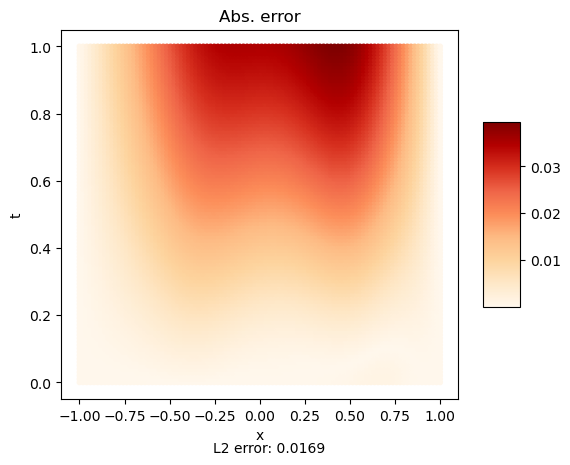

model # of parameters 920
reject move
reject move
steps  30 accept move
Loss = 0.0006195710771352415 Loss new= 0.00013688154433785042
Elapsed: 49.8ms
steps  40 accept move
Loss = 3.395997695090373e-05 Loss new= 2.7317595258948615e-05
Elapsed: 39.9ms
steps  50 accept move
Loss = 1.6002556581803836e-05 Loss new= 1.466684283074121e-05
Elapsed: 39.5ms
steps  60 accept move
Loss = 1.1015396105451968e-05 Loss new= 1.0356154847762143e-05
Elapsed: 41.7ms
steps  70 accept move
Loss = 8.29966883742319e-06 Loss new= 7.893591976068698e-06
Elapsed: 48.9ms
steps  80 accept move
Loss = 6.5621820411546276e-06 Loss new= 6.287484208104651e-06
Elapsed: 42.8ms
steps  90 accept move
Loss = 5.358257312763894e-06 Loss new= 5.160899766082918e-06
Elapsed: 41.8ms
steps  100 accept move
Loss = 4.478253866688626e-06 Loss new= 4.3301860376150625e-06
Elapsed: 42.7ms
steps  10 accept move
Loss = 2.3197153360747057e-05 Loss new= 1.96333042536577e-05
Elapsed: 40.5ms
steps  20 accept move
Loss = 1.1454087705548852e-05 

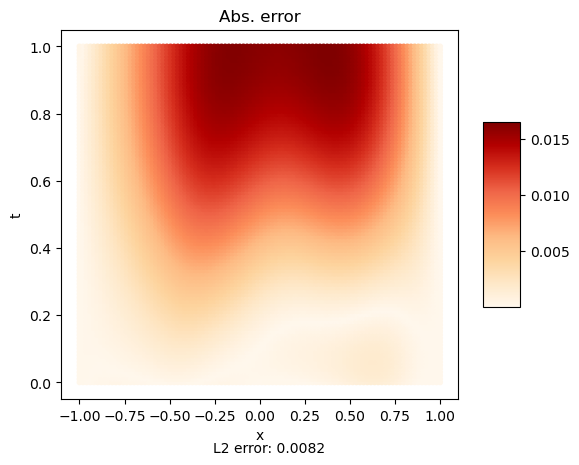

model # of parameters 920
steps  10 accept move
Loss = 0.08547403756902879 Loss new= 0.046936273110549244
Elapsed: 51.2ms
reject move
reject move
reject move
steps  50 accept move
Loss = 3.853057633340547e-05 Loss new= 2.347966429035631e-05
Elapsed: 40.0ms
steps  60 accept move
Loss = 1.3732147941044996e-05 Loss new= 1.2706494451135102e-05
Elapsed: 38.4ms
steps  70 accept move
Loss = 9.929779670142222e-06 Loss new= 9.42545987499822e-06
Elapsed: 38.0ms
steps  80 accept move
Loss = 7.815157230003118e-06 Loss new= 7.487428943881531e-06
Elapsed: 51.5ms
steps  90 accept move
Loss = 6.382188806955922e-06 Loss new= 6.147584666852732e-06
Elapsed: 36.4ms
steps  100 accept move
Loss = 5.335603441624406e-06 Loss new= 5.159407421868062e-06
Elapsed: 38.5ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps 

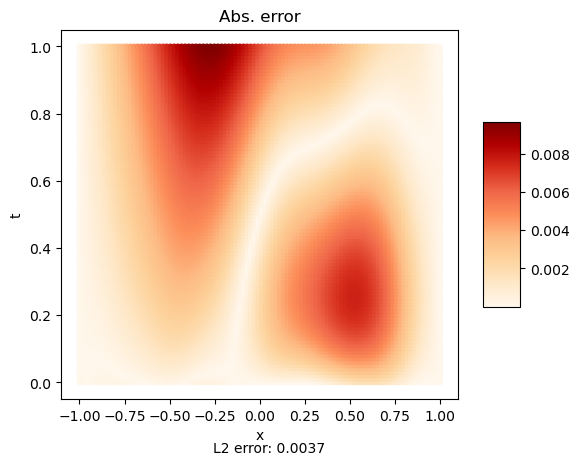

model # of parameters 920
steps  10 accept move
Loss = 0.38640393958298913 Loss new= 0.12900824143989592
Elapsed: 41.7ms
reject move
reject move
reject move
steps  50 accept move
Loss = 5.179643864560547e-05 Loss new= 3.8425903349644286e-05
Elapsed: 38.8ms
steps  60 accept move
Loss = 1.95646633899741e-05 Loss new= 1.7224615722507292e-05
Elapsed: 46.0ms
steps  70 accept move
Loss = 1.1126668972556024e-05 Loss new= 1.0182243964143509e-05
Elapsed: 54.6ms
steps  80 accept move
Loss = 7.769737574768363e-06 Loss new= 7.389453612858904e-06
Elapsed: 43.8ms
steps  90 accept move
Loss = 6.3064806414916426e-06 Loss new= 6.104770780307397e-06
Elapsed: 50.2ms
steps  100 accept move
Loss = 5.4480228422449186e-06 Loss new= 5.3109203376943026e-06
Elapsed: 50.8ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 3.946096793567459e-06 Loss new= 3.6071064727373137e-06
Elapsed: 45.0ms
reject move
reject mov

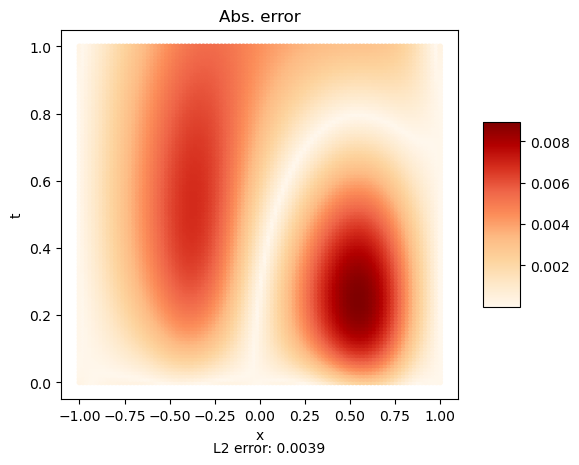

model # of parameters 920
reject move
reject move
reject move
reject move
steps  50 accept move
Loss = 0.00013272266851989555 Loss new= 0.00013146039752847283
Elapsed: 102.2ms
steps  60 accept move
Loss = 1.5541785953691542e-05 Loss new= 1.2858251420300655e-05
Elapsed: 54.5ms
steps  70 accept move
Loss = 7.841969551661617e-06 Loss new= 7.216652320894708e-06
Elapsed: 46.5ms
steps  80 accept move
Loss = 5.6078788012004e-06 Loss new= 5.335195068064333e-06
Elapsed: 44.9ms
steps  90 accept move
Loss = 4.508423307764854e-06 Loss new= 4.3477963842818965e-06
Elapsed: 53.2ms
steps  100 accept move
Loss = 3.82193964451381e-06 Loss new= 3.7129518416802568e-06
Elapsed: 51.4ms
steps  10 accept move
Loss = 4.15167481013272e-05 Loss new= 3.497265281520099e-05
Elapsed: 45.5ms
steps  20 accept move
Loss = 2.1121181018939384e-05 Loss new= 1.9191763935062185e-05
Elapsed: 53.4ms
steps  30 accept move
Loss = 1.4355155611826388e-05 Loss new= 1.3563237904681436e-05
Elapsed: 48.5ms
steps  40 accept move
Loss 

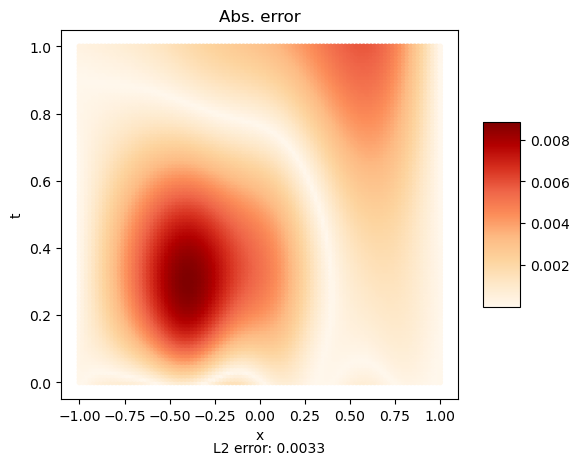

model # of parameters 920
steps  10 accept move
Loss = 0.2337167782674593 Loss new= 0.16944070646066192
Elapsed: 47.8ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 2.5766591709379083e-06 Loss new= 1.5508924867980017e-06
Elapsed: 49.4ms
steps  20 accept move
Loss = 1.0345428178414981e-07 Loss new= 6.839887331582709e-08
Elapsed: 54.1ms
steps  30 accept move
Loss = 3.6257139048990076e-08 Loss new= 3.412801461758195e-08
Elapsed: 52.5ms
steps  40 accept move
Loss = 2.8819693202995043e-08 Loss new= 2.7861621417391962e-08
Elapsed: 50.5ms
steps  50 accept move
Loss = 2.4747827909131456e-08 Loss new= 2.409916674906808e-08
Elapsed: 50.4ms
steps  60 accept move
Loss = 2.1847145551476077e-08 Loss new= 2.135154725590785e-08
Elapsed: 59.5ms
steps  70 accept move
Loss = 1.9566132365542578e-08 Loss new= 1.9160949766766026e-08
Elapsed: 45.2ms
steps  80 accept move
Loss = 1.7670887163707236e-08 Loss new= 1.73269

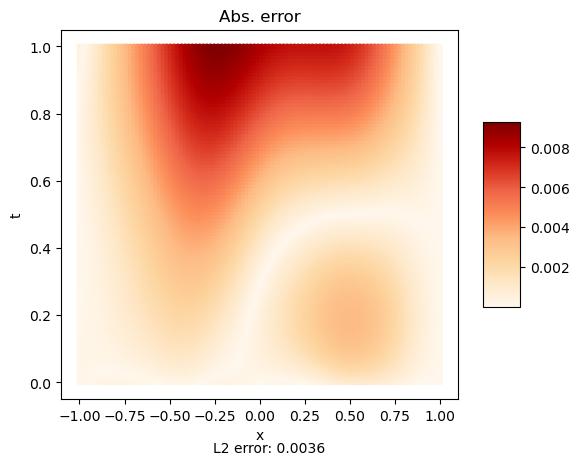

model # of parameters 920
reject move
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 2.771508111761742e-05 Loss new= 1.5448218861408338e-05
Elapsed: 57.5ms
steps  70 accept move
Loss = 6.533035539115483e-06 Loss new= 5.699864492410136e-06
Elapsed: 53.7ms
steps  80 accept move
Loss = 3.6217952405981856e-06 Loss new= 3.288844936821738e-06
Elapsed: 53.2ms
steps  90 accept move
Loss = 2.357091001599133e-06 Loss new= 2.1936232994417556e-06
Elapsed: 67.4ms
steps  100 accept move
Loss = 1.7071292801961034e-06 Loss new= 1.6162355869963081e-06
Elapsed: 55.3ms
steps  10 accept move
Loss = 2.7889242985734063e-05 Loss new= 1.762444719529337e-05
Elapsed: 52.1ms
steps  20 accept move
Loss = 5.493655875390955e-06 Loss new= 4.604327569247958e-06
Elapsed: 51.1ms
steps  30 accept move
Loss = 3.0912555477778504e-06 Loss new= 2.939318367244653e-06
Elapsed: 56.5ms
steps  40 accept move
Loss = 2.5891486063379143e-06 Loss new= 2.531078609816336e-06
Elapsed: 55.7ms
reject move
re

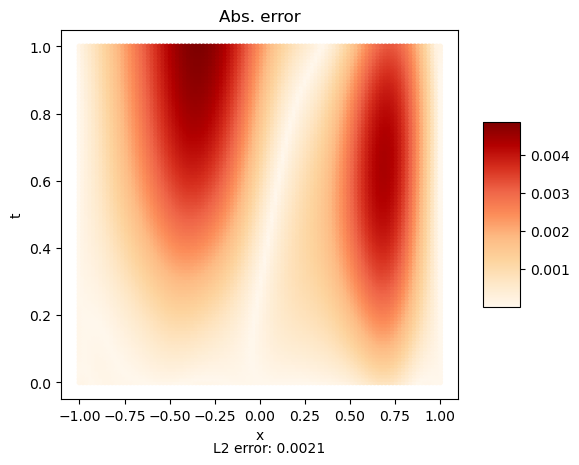

model # of parameters 920
steps  10 accept move
Loss = 0.06751385390092687 Loss new= 0.023342634661527608
Elapsed: 55.5ms
reject move
steps  30 accept move
Loss = 0.0003881504391070202 Loss new= 0.0002468060944425344
Elapsed: 121.7ms
steps  40 accept move
Loss = 2.005929390397377e-05 Loss new= 1.673856941071314e-05
Elapsed: 57.5ms
steps  50 accept move
Loss = 9.884609835680115e-06 Loss new= 8.913824676384453e-06
Elapsed: 65.5ms
steps  60 accept move
Loss = 6.324298362798902e-06 Loss new= 5.8887626016447916e-06
Elapsed: 57.3ms
steps  70 accept move
Loss = 4.62912005004223e-06 Loss new= 4.399731814536622e-06
Elapsed: 53.5ms
steps  80 accept move
Loss = 3.6916385202337463e-06 Loss new= 3.5532787744222123e-06
Elapsed: 68.1ms
steps  90 accept move
Loss = 3.1017320485553932e-06 Loss new= 3.00871582061879e-06
Elapsed: 57.6ms
reject move
steps  10 accept move
Loss = 2.7050063818155882e-05 Loss new= 2.268535450339851e-05
Elapsed: 55.1ms
steps  20 accept move
Loss = 1.2133338094712427e-05 Loss n

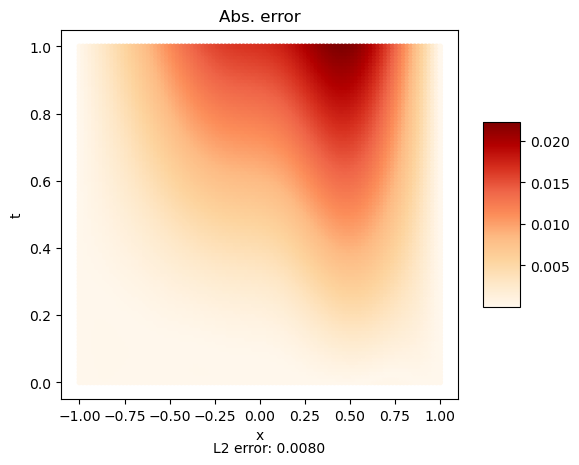

model # of parameters 920
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 1.6889633751173743e-06 Loss new= 1.5169771102642605e-06
Elapsed: 46.1ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 1.1111034229736618e-06 Loss new= 9.86313574052131e-07
Elapsed: 44.7ms
steps  20 accept move
Loss = 7.076056226549951e-07 Loss new= 6.632120483895492e-07
Elapsed: 56.3ms
steps  30 accept move
Loss = 5.294619784286246e-07 Loss new= 5.035212489700039e-07
Elapsed: 47.8ms
reject move
reject move
reject move
reject move
steps  80 accept move
Loss = 1.580473427458208e-08 Loss new=

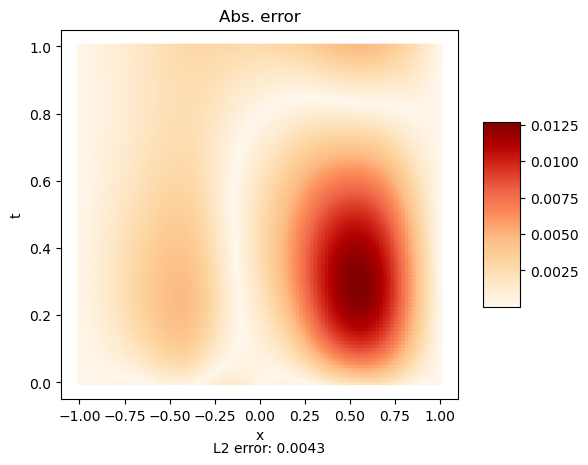

model # of parameters 920
reject move
reject move
steps  30 accept move
Loss = 2.4400223207209975e-05 Loss new= 1.9738952694378153e-05
Elapsed: 52.9ms
steps  40 accept move
Loss = 1.0381295650798208e-05 Loss new= 9.08844948387366e-06
Elapsed: 55.1ms
steps  50 accept move
Loss = 5.673374984445788e-06 Loss new= 5.108119881356608e-06
Elapsed: 58.8ms
steps  60 accept move
Loss = 3.5220793540769673e-06 Loss new= 3.247807955595742e-06
Elapsed: 54.9ms
steps  70 accept move
Loss = 2.455607130315626e-06 Loss new= 2.3134112428093638e-06
Elapsed: 53.8ms
steps  80 accept move
Loss = 1.8850970812588955e-06 Loss new= 1.8040061444680834e-06
Elapsed: 52.7ms
steps  90 accept move
Loss = 1.5470295700626727e-06 Loss new= 1.4956550575215782e-06
Elapsed: 57.3ms
steps  100 accept move
Loss = 1.3256129257049254e-06 Loss new= 1.2901818919101149e-06
Elapsed: 57.5ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss 

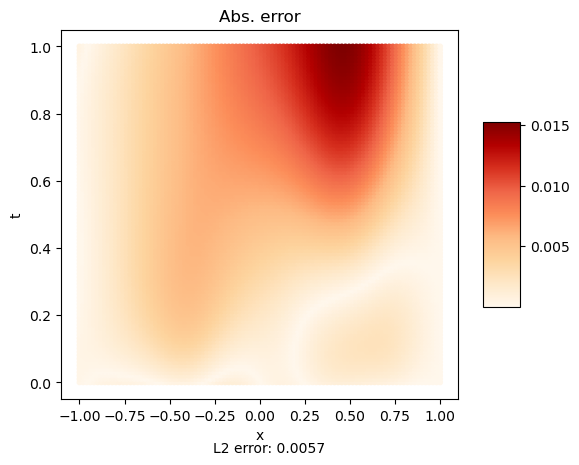

model # of parameters 920
reject move
reject move
steps  30 accept move
Loss = 3.1526312155116814e-05 Loss new= 2.4750071319182126e-05
Elapsed: 53.0ms
steps  40 accept move
Loss = 1.2219148762035662e-05 Loss new= 1.0505132348657631e-05
Elapsed: 56.0ms
steps  50 accept move
Loss = 5.994619831301955e-06 Loss new= 5.270695349870437e-06
Elapsed: 59.7ms
steps  60 accept move
Loss = 3.3288068861087383e-06 Loss new= 3.0086858235720408e-06
Elapsed: 56.3ms
steps  70 accept move
Loss = 2.1140834700559044e-06 Loss new= 1.959735341168587e-06
Elapsed: 61.0ms
steps  80 accept move
Loss = 1.5151629951531444e-06 Loss new= 1.4357914364841553e-06
Elapsed: 57.4ms
steps  90 accept move
Loss = 1.1984554391954868e-06 Loss new= 1.1539425958569044e-06
Elapsed: 56.6ms
reject move
steps  10 accept move
Loss = 2.4657383492193616e-05 Loss new= 1.9763712920446517e-05
Elapsed: 56.9ms
steps  20 accept move
Loss = 1.252512051052796e-05 Loss new= 1.1450602854442894e-05
Elapsed: 59.1ms
steps  30 accept move
Loss = 8.24

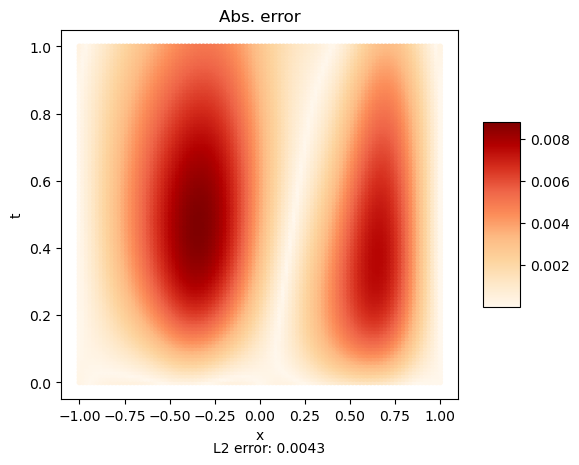

In [23]:
import plot_l2error
# 创建一个空字典来存储损失数组
loss_dict = {}
torch.cuda.empty_cache() 
avg_time=np.zeros(21)
error=np.zeros(21)
for j in range(21):
    pinns_ran=PINN_S()
    for i in range(20):
        pinns_ran.new_sampling(9+i)
        pinns_ran.LM(20+45*j,100,True)
    avg_time[j]=pinns_ran.avg_time
    error[j]=plot_l2error.plot_model_error(pinns_ran.model, (-1, 1), (0, 1), device='cuda')
    loss_dict[f"loss {20+45*j} params"]=pinns_ran.loss_record
x_axis=np.arange(20,920+45,45)


### 图像


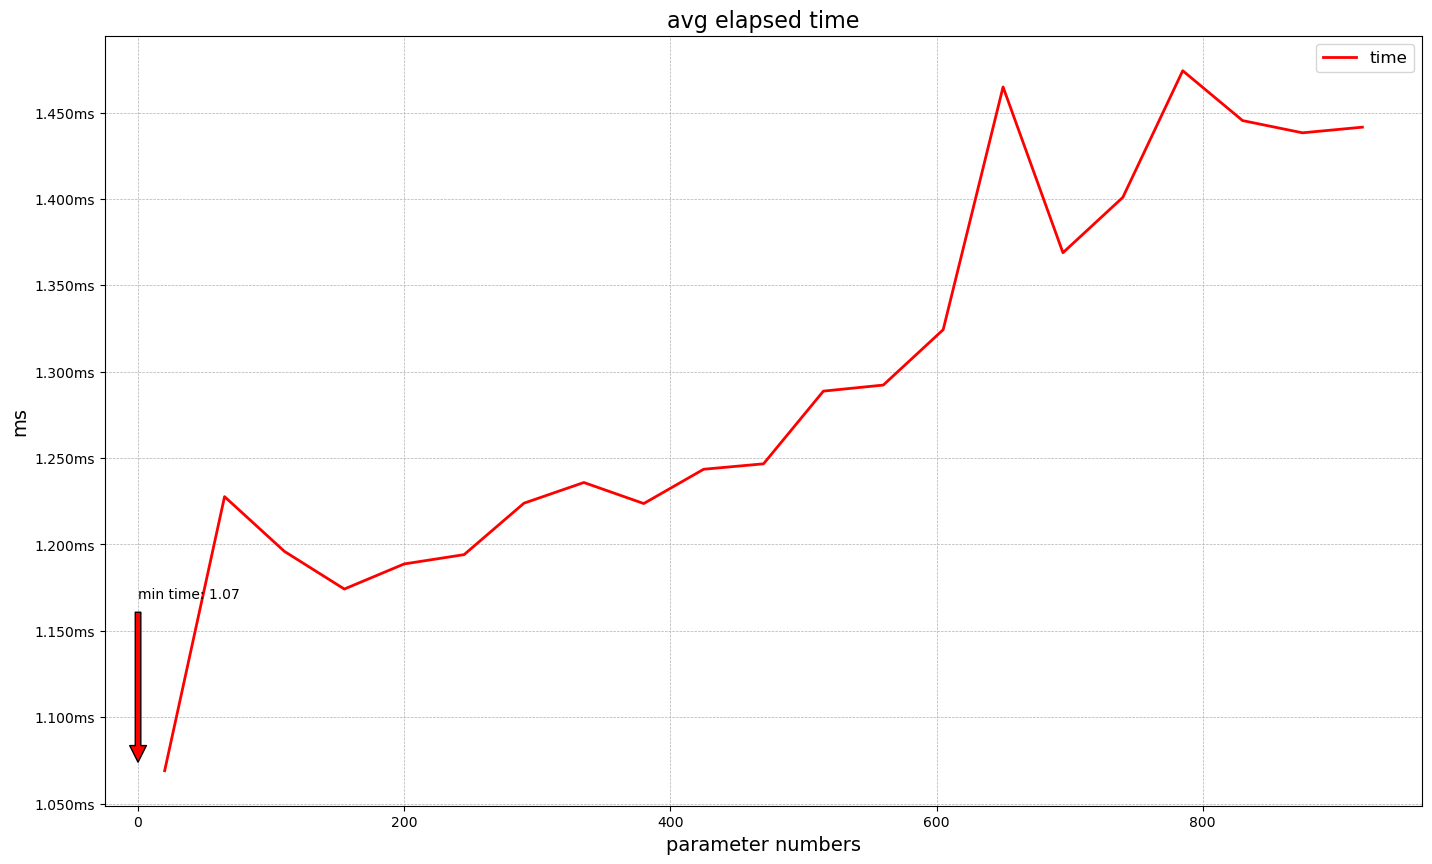

In [9]:
import plot_time
plot_time.plot_time(avg_time,x_axis,'r','-')


C:\Windows\Temp\ipykernel_21240\1349603443.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(loss_dict['loss 740 params']))


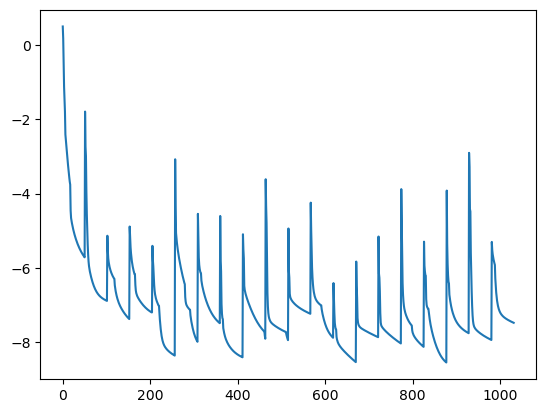

In [21]:
plt.plot(np.log10(loss_dict['loss 740 params']))

error 0.0187325799962605


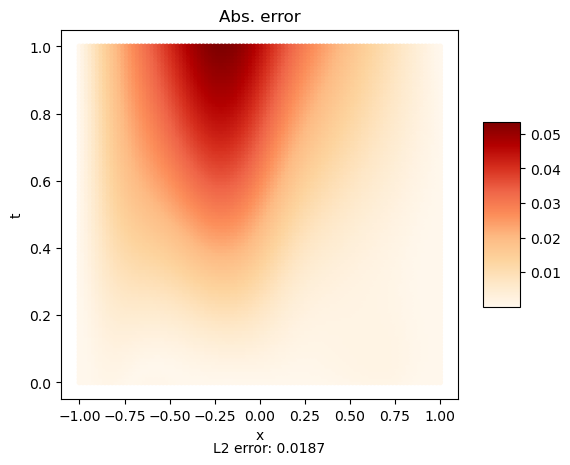

NameError: name 'pinns_ran' is not defined

In [9]:
import plot_l2error
plot_l2error.plot_model_error(pinns_all.model, (-1, 1), (0, 1), device='cuda')
plot_l2error.plot_model_error(pinns_ran.model, (-1, 1), (0, 1), device='cuda')

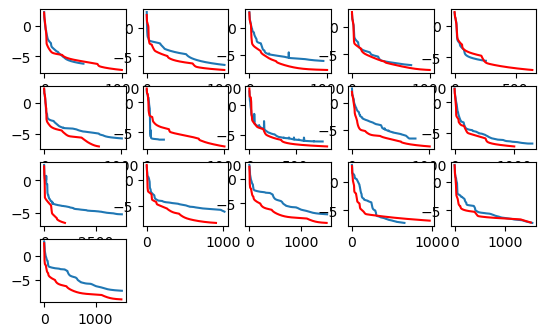

In [29]:
import numpy as np
import matplotlib.pyplot as plt

figure = plt.figure()

# 循环处理每个子图和数据文件

ax = figure.add_subplot(5, 5, i)
    
# 加载并处理第i个数据文件
loss = np.load(f"losspinns_record{i}.npy")
loss = np.log10(loss[loss != 0])
ax.plot(loss)
    
loss_all = np.load(f"losspinnsall_record{i}.npy")
loss_all = np.log10(loss_all[loss_all != 0])
ax.plot(loss_all, 'r')

plt.show()